# Semantic Similarity - Experiment 02
The objective of this trial is to expand the SCA_index (i.e., Semantic Content Analysis Index) to a full word embedding, setting a subjective or objective load for each word.

version 2: using SpaCy Universal Sentence Encoder, which means vectors with dimension 512 instead of 300.

## Introduction

### Libraries

In [6]:
## Data analysis packages:
import pandas as pd
import numpy as np
#from math import isnan  #Verifies if a given value is numerical.
#import re  # Regular Expression

In [7]:
## Visualization packages:
# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
## MLOps:
import pickle

### Definitions

In [9]:
## Forcing Pandas to display any number of elements
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', None)

## SpaCy Word Embeddings (WE): 
Also using Spacy library: https://spacy.io/
> !pip install -U spacy  
> !python -m spacy download en_core_web_sm  
> !python -m spacy download en_core_web_lg

Some instructions on how to use it:  
https://spacy.io/usage/spacy-101

In [10]:
## Importing SpaCy library:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_lg")

In [11]:
## We check below that this model has 514.157 keys and vectors, respectively.
nlp.meta['vectors']

{'width': 300,
 'vectors': 514157,
 'keys': 514157,
 'name': 'en_vectors',
 'mode': 'default'}

In [12]:
## Again, checking the number of keys.
nlp.vocab.vectors.n_keys

514157

In [13]:
## Finding the SpaCy index for a given word:
nlp.vocab.strings['problem']

4473158105997569131

In [14]:
## Getting the text and vector for a given index:
tmp_Idx = 4473158105997569131

tmp_vector = nlp.vocab[tmp_Idx].vector
tmp_text = nlp.vocab[tmp_Idx].text

In [15]:
print(f'{tmp_Idx}: {tmp_text}:\n{tmp_vector[0:3]}...')

4473158105997569131: problem:
[ 3.3611  4.0891 -2.1247]...


In [17]:
import spacy_universal_sentence_encoder

In [19]:
nlp = spacy_universal_sentence_encoder.load_model('en_use_md')

In [25]:
## Defining a method to get vector and text information for a word:
def nlp_getVector(word, verbose=False):
    '''
    Obtains the vector representation of a given word from SpaCy word embedding.
    Usage:  nlp_getVector(word)[0] to get the text; nlp_getVector(word)[1] to get the vector.
            var_text, var_vector = nlp_getVector(word)
    '''
    ## Generates the word hash:
    # hash = nlp.vocab.strings[word]
    try:
        word_vector = nlp(word).vector
        word_text = nlp(word).text
    except:
        if verbose:
            print('Error: word vector not available.')
        return None
    return (word_text, word_vector)

In [26]:
## Testing the method:
print(f'Word: {nlp_getVector("study")[0]} <-> Vector 3rd elements: {nlp_getVector("study")[1][:3]}')

Word: study <-> Vector 3rd elements: [-0.00239888 -0.06967633  0.0222383 ]


---
## Semantic Content Analysis (SCA)
* Read the SCA obtained from Glasgow Norms data;  
* Import F_s and F_o from the previous study;  
* Generate datasets for training classifiers.

In [27]:
df_factors = pd.read_csv('../data/df_factors.csv', sep=';')
df_factors.head()

,words,F_Objectivity,F_Subjectivity,F_Context
0,abattoir,0.512527,0.380603,0.960466
1,abbey,0.714765,0.240456,0.696198
2,abbreviate,0.286952,0.171052,0.767043
3,abdicate,0.144736,0.384300,0.863127
4,abdication,0.167654,0.334086,0.896733


### De-Duplicating words  
There are words in the Glasgow Norms that were differentiated from their homonymous, such as 'case'. In this section, we first select those words and then input a mean value for them.

In [28]:
## Exemplifying the need for de-duplication:
df_factors[df_factors['words'].str.contains('case')]

,words,F_Objectivity,F_Subjectivity,F_Context
533,bookcase,0.926393,0.374441,0.335542
756,case,0.715863,0.164100,0.409611
757,case (container),0.821136,0.079956,0.400335
758,case (instance),0.233820,0.213528,0.651273
759,case (legal),0.456260,0.369828,0.733642
4808,suitcase,0.961068,0.256584,0.356338


In [29]:
## Creating a new dataframe by splitting the 'words' column into two columns:
df_homonym = df_factors.copy()
df_homonym[['word','distinction']] = df_homonym['words'].str.split('(', expand=True)
## Renaming the columns of the new dataframe:
# df_homonym.columns = ['word','distinction']

# Stripping whitespace from the new columns
df_homonym['word'] = df_homonym['word'].str.strip()
df_homonym['distinction'] = df_homonym['distinction'].str.strip().str.rstrip(')')

## Showing dataframe:
df_homonym.head(5)

,words,F_Objectivity,F_Subjectivity,F_Context,word,distinction
0,abattoir,0.512527,0.380603,0.960466,abattoir,None
1,abbey,0.714765,0.240456,0.696198,abbey,None
2,abbreviate,0.286952,0.171052,0.767043,abbreviate,None
3,abdicate,0.144736,0.384300,0.863127,abdicate,None
4,abdication,0.167654,0.334086,0.896733,abdication,None


In [30]:
# Calculating the number of distinct elements in the 'distinction' column for each word in the 'word' column
distinct_count = df_homonym.groupby('word')['distinction'].nunique().reset_index()

# Counting the frequency of different numbers of distinct elements
pivot_table = distinct_count.groupby('distinction')['word'].count().reset_index()

# Renaming the columns
pivot_table.columns = ['n_distinction', 'n_words']
pivot_table

,n_distinction,n_words
0,0,4303
1,1,2
2,2,288
3,3,69
4,4,19
5,5,2


#### Analyzing the words with 5 distinct meaning:

In [31]:
## Getting the word with the highest number of distinct meanings: 
distinct_count[distinct_count['distinction'] == 5]

,word,distinction
721,charge,5
822,club,5


In [32]:
df_homonym[(df_homonym['word']=='club') | (df_homonym['word']=='charge')]

,words,F_Objectivity,F_Subjectivity,F_Context,word,distinction
819,charge,0.340881,0.330534,0.438418,charge,None
820,charge (card),0.477083,0.293352,0.671798,charge,card
821,charge (dependent),0.256759,0.164572,0.791042,charge,dependent
822,charge (electric),0.391504,0.413080,0.697287,charge,electric
823,charge (price),0.428509,0.353942,0.498770,charge,price
824,charge (rush),0.551191,0.557549,0.591914,charge,rush
942,club,0.774815,0.476734,0.467275,club,None
943,club (card suit),0.773094,0.187918,0.492067,club,card suit
944,club (disco),0.863845,0.547812,0.658553,club,disco
945,club (hit),0.725571,0.435103,0.607930,club,hit


#### Replacing the distinct values for the average (column 'word'):

In [33]:
# Calculating the mean of F_Objectivity and F_Subjectivity for each group of "word"
mean_values = df_homonym.groupby('word')[['F_Objectivity', 'F_Subjectivity']].mean().reset_index()

In [34]:
mean_values

,word,F_Objectivity,F_Subjectivity
0,Apple,0.940620,0.524376
1,Christmas,0.850793,0.833898
2,Dad,0.856533,0.493834
3,Dame,0.626968,0.300580
4,FALSE,0.156905,0.473624
...,...,...,...
4678,zeppelin,0.864760,0.396531
4679,zero,0.379392,0.315118
4680,zest,0.402894,0.476800
4681,zoo,0.867152,0.507390


In [35]:
## Merging the mean values back into the original DataFrame
df = pd.merge(df_homonym, mean_values, on='word', suffixes=('', '_mean'))

## Checking an example (is the "_mean" values equal for all instances?): 
df[df['word'] == 'charge']

,words,F_Objectivity,F_Subjectivity,F_Context,word,distinction,F_Objectivity_mean,F_Subjectivity_mean
819,charge,0.340881,0.330534,0.438418,charge,None,0.407655,0.352172
820,charge (card),0.477083,0.293352,0.671798,charge,card,0.407655,0.352172
821,charge (dependent),0.256759,0.164572,0.791042,charge,dependent,0.407655,0.352172
822,charge (electric),0.391504,0.413080,0.697287,charge,electric,0.407655,0.352172
823,charge (price),0.428509,0.353942,0.498770,charge,price,0.407655,0.352172
824,charge (rush),0.551191,0.557549,0.591914,charge,rush,0.407655,0.352172


In [36]:
## Dropping duplicated words (by column)
df.drop_duplicates(subset=['word'], inplace=True)

## Selecting only the columns of interest:
df = df[['word', 'F_Objectivity_mean', 'F_Subjectivity_mean']]

## Renaming the columns to remove the "_mean" suffix
df.rename(columns={'F_Objectivity_mean': 'F_Objectivity', 'F_Subjectivity_mean': 'F_Subjectivity'}, inplace=True)

In [37]:
## Showing dataframe:
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4683 entries, 0 to 5552
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   word            4683 non-null   object 
 1   F_Objectivity   4683 non-null   float64
 2   F_Subjectivity  4683 non-null   float64
dtypes: float64(2), object(1)
memory usage: 146.3+ KB
None


,word,F_Objectivity,F_Subjectivity
0,abattoir,0.512527,0.380603
1,abbey,0.714765,0.240456
2,abbreviate,0.286952,0.171052
3,abdicate,0.144736,0.384300
4,abdication,0.167654,0.334086


In [38]:
## Saving the prepared data:
# df.to_csv('../data/df_factors_prepared.csv')

In [39]:
# ### Selecionando apenas as palavras no df_factors que atendam aos critérios:
# df_selected = df.loc[((df['F_Subjectivity'] > 0.75) | (df['F_Subjectivity'] < 0.3)) & ((df['F_Objectivity'] > 0.75) | (df['F_Objectivity'] < 0.3))]
# df_factors = df_selected.copy()

In [40]:
## Generating a list of words from SCA for training.
SCA_words = [word for word in df.word]
len(SCA_words)

4683

In [41]:
## Preparing dataframe for training:
# df.set_index('word', inplace=True)

In [42]:
df

,word,F_Objectivity,F_Subjectivity
0,abattoir,0.512527,0.380603
1,abbey,0.714765,0.240456
2,abbreviate,0.286952,0.171052
3,abdicate,0.144736,0.384300
4,abdication,0.167654,0.334086
...,...,...,...
5548,zeppelin,0.864760,0.396531
5549,zero,0.379392,0.315118
5550,zest,0.402894,0.476800
5551,zoo,0.867152,0.507390


## DataPrep for machine learning classifiers
This section prepares data from Semantic Content Analysis (SCA) and Word Embedding (WE) sources for machine learning classification tasks. Steps include data integration, cleaning, feature engineering, transformation, and splitting into training and test sets for linear and multilabel classification. The goal is to optimize data quality and model performance.

In [43]:
from sklearn.model_selection import train_test_split

# Splitting data in train (75%) and test (25%)
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

In [44]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3512 entries, 213 to 1012
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   word            3512 non-null   object 
 1   F_Objectivity   3512 non-null   float64
 2   F_Subjectivity  3512 non-null   float64
dtypes: float64(2), object(1)
memory usage: 109.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1171 entries, 513 to 3371
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   word            1171 non-null   object 
 1   F_Objectivity   1171 non-null   float64
 2   F_Subjectivity  1171 non-null   float64
dtypes: float64(2), object(1)
memory usage: 36.6+ KB
None


In [45]:
def generateData(df_sca:pd.DataFrame):
    '''Creates a dataset with explanatory variables from word embedding and dependent variables based on the SCA target data.
    Usage example: "X_train, Y_train = generateData(df)"
    Input: Pandas.DataFrame with SCA words.
    Output: X: dataframe with explanatory variables; Y: dataframe with dependent variables.
    '''
    X = {}
    Y = {}
    
    for i, row in df_sca.iterrows():
        word = row['word']
        f_objectivity = row['F_Objectivity']
        f_subjectivity = row['F_Subjectivity']

        try:
            X[word] = nlp_getVector(word)[1]  # Stores the word vector
            Y[word] = {'F_Objectivity': f_objectivity, 'F_Subjectivity': f_subjectivity}
            # print(f'Debug: {word} <=> {nlp_getVector(word)[0]}')
        except:
            pass

    return pd.DataFrame.from_dict(X, orient='index'), pd.DataFrame.from_dict(Y, orient='index')

### A) Regression models: splitting train and test data
- Multi output (F_obj, F_sub), with continuous values.

In [46]:
## Generating data:
X_train_A, Y_train_A = generateData(train_df)
X_test_A, Y_test_A = generateData(test_df)

In [47]:
## Checking the generated data dimension:
print("Train data dimension:")
print("X_train:", X_train_A.shape)
print("Y_train:", Y_train_A.shape)

print("\nTest data dimension:")
print("X_test:", X_test_A.shape)
print("Y_test:", Y_test_A.shape)

Train data dimension:
X_train: (3512, 512)
Y_train: (3512, 2)

Test data dimension:
X_test: (1171, 512)
Y_test: (1171, 2)


In [48]:
X_train_A

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
argument,-0.057584,0.000001,0.055926,0.025750,-0.052444,0.034983,0.072001,-0.062773,0.030634,0.023789,-0.030285,-0.016392,0.016137,0.018487,-0.045962,-0.081218,0.008702,0.087169,-0.019983,0.016165,-0.043445,0.015750,0.040670,0.019039,-0.030091,0.067343,-0.035152,-0.050932,-0.050478,0.007857,-0.023909,-0.036066,-0.063819,0.013660,-0.014213,0.032831,0.000128,0.022295,0.008915,0.029342,-0.039961,-0.011504,-0.005429,-0.018344,0.014334,-0.029569,-0.039182,-0.017273,0.018854,-0.044364,-0.009508,-0.038428,0.079336,0.033354,-0.017089,0.014819,-0.034245,-0.020829,0.073357,0.018781,0.017274,0.027938,-0.058285,0.033429,0.038148,0.050036,-0.042139,-0.039587,0.062817,0.018287,-0.049389,-0.006416,0.011627,0.043233,-0.030799,0.045815,-0.031661,0.017208,0.046690,0.001913,0.039871,0.023903,-0.036332,-0.020771,-0.007836,0.065198,-0.034911,0.015282,-0.012333,0.028438,0.031518,-0.019205,-0.062143,-0.015026,0.054232,0.005134,0.049093,-0.014332,0.045847,-0.008020,0.004010,-0.046933,0.040072,-0.004521,0.005188,-0.010432,-0.014471,0.024448,-0.023686,0.004382,0.004548,-0.079834,-0.032111,0.024725,-0.007961,-0.015412,0.007960,0.043120,-0.000988,0.085556,-0.087542,0.027295,0.024891,-0.052877,0.050715,0.041792,-0.029795,-0.058189,-0.063624,0.034922,-0.059336,0.023104,0.046315,0.058178,0.033994,0.054983,0.086336,-0.060357,-0.057711,0.042543,-0.040400,-0.031473,0.030364,-0.046617,0.000323,-0.003256,-0.023044,-0.019966,0.065511,-0.036345,-0.021797,-0.000303,-0.054354,0.008926,-0.061933,-0.069910,-0.071256,-0.071903,-0.064597,0.018952,0.009328,-0.000932,0.050384,-0.028000,0.038387,0.045326,-0.062275,-0.051920,0.024715,0.028655,-0.041929,-0.075593,-0.051104,-0.061172,0.004018,0.023573,0.047923,-0.012488,0.018772,0.066610,-0.045729,0.020685,-0.059596,0.059906,-0.006771,-0.010002,-0.010421,0.034321,-0.067768,-0.058326,0.077001,0.012309,0.013914,0.038823,0.062681,-0.090058,0.053686,-0.003382,0.015303,-0.051602,-0.041136,-0.052476,0.023577,0.081222,-0.057633,0.024575,-0.070626,-0.058188,-0.040819,-0.009062,-0.082470,-0.013702,0.042660,-0.021233,-0.024118,-0.0274

In [49]:
Y_train_A

,F_Objectivity,F_Subjectivity
argument,0.365722,0.647198
awful,0.201122,0.507171
decorator,0.774472,0.291107
misconception,0.013464,0.474901
crab,0.816438,0.227631
...,...,...
vaccinate,0.678125,0.443751
boastful,0.437815,0.575248
phrase,0.265757,0.144886
ski,0.900524,0.370531


### B) Multilabel classification: splitting train and test data
- The model predicts multiple classes for a single instance.  
- In this case, it predicts high or low objectivity and subjectivity (i.e., four classes).

In [50]:
## Generating data (the same process for dataset A):
X_train_B, Y_train_B = generateData(train_df)
X_test_B, Y_test_B = generateData(test_df)

In [51]:
# # Categorical labeling through list comprehension accordingly to SCA median criteria:
# Y_train_B['F_Objectivity'] = ['high' if f_objectivity >= 0.565 else 'low' for f_objectivity in Y_train_B['F_Objectivity']]
# Y_train_B['F_Subjectivity'] = ['high' if f_subjectivity >= 0.392 else 'low' for f_subjectivity in Y_train_B['F_Subjectivity']]

# Y_test_B['F_Objectivity'] = ['high' if f_objectivity >= 0.565 else 'low' for f_objectivity in Y_test_B['F_Objectivity']]
# Y_test_B['F_Subjectivity'] = ['high' if f_subjectivity >= 0.392 else 'low' for f_subjectivity in Y_test_B['F_Subjectivity']]

In [52]:
# Categorical binary labeling through list comprehension accordingly to SCA median criteria:
Y_train_B['F_Objectivity'] = [1 if f_objectivity >= 0.565 else 0 for f_objectivity in Y_train_B['F_Objectivity']]
Y_train_B['F_Subjectivity'] = [1 if f_subjectivity >= 0.392 else 0 for f_subjectivity in Y_train_B['F_Subjectivity']]

Y_test_B['F_Objectivity'] = [1 if f_objectivity >= 0.565 else 0 for f_objectivity in Y_test_B['F_Objectivity']]
Y_test_B['F_Subjectivity'] = [1 if f_subjectivity >= 0.392 else 0 for f_subjectivity in Y_test_B['F_Subjectivity']]

In [53]:
## Checking the generated data dimension:
print("Train data dimension:")
print("X_train:", X_train_B.shape)
print("Y_train:", Y_train_B.shape)

print("\nTest data dimension:")
print("X_test:", X_test_B.shape)
print("Y_test:", Y_test_B.shape)

Train data dimension:
X_train: (3512, 512)
Y_train: (3512, 2)

Test data dimension:
X_test: (1171, 512)
Y_test: (1171, 2)


In [54]:
Y_train_B.sample(5)

,F_Objectivity,F_Subjectivity
coke,1,0
accelerate,0,1
needle,1,0
fierce,0,1
lie,0,1


### C) Multiclass classification: splitting train and test data
- The model predicts between more than two mutually exclusive classes.  
- In this case, it will predict between its semantic content: latent, manifest, contextual, or perceptual.  

In [55]:
## It makes use of Y_train_B and Y_test_B data.
Y_train_C = Y_train_B.copy()
Y_test_C = Y_test_B.copy()

## It also makes a copy of X datasets:
X_train_C = X_train_B.copy()
X_test_C = X_test_B.copy()

In [56]:
# Defines a method to map values from columns to the respective labels according to SCA analysis.
def map_labels(row):
    if row['F_Objectivity'] == 0 and row['F_Subjectivity'] == 1:
        return 'Latent'
    elif row['F_Objectivity'] == 0 and row['F_Subjectivity'] == 0:
        return 'Contextual'
    elif row['F_Objectivity'] == 1 and row['F_Subjectivity'] == 0:
        return 'Manifest'
    elif row['F_Objectivity'] == 1 and row['F_Subjectivity'] == 1:
        return 'Perceptual'

In [57]:
# Maps Y_train_C, Y_test_C values into a target column:
Y_train_C['target'] = Y_train_C.apply(map_labels, axis=1)
Y_test_C['target'] = Y_test_C.apply(map_labels, axis=1)

In [58]:
## Dropping unnecessariy columns:
Y_train_C.drop(['F_Objectivity','F_Subjectivity'], axis=1, inplace=True)
Y_test_C.drop(['F_Objectivity','F_Subjectivity'], axis=1, inplace=True)

In [59]:
Y_train_C.sample(5)

,target
koala,Perceptual
none,Contextual
beaker,Manifest
advise,Latent
conceal,Latent


In [60]:
## All training data, except for train_D are equals:
X_train_B.equals(X_train_C) & X_train_A.equals(X_train_B)

True

### D) MAD selection data
Since SCA uses the median as a measure of centrality instead of the mean, we will consider the median absolute deviation (MAD) as an equivalent to standard deviation. MAD is a robust measure of variability that is less sensitive to outliers compared to the standard deviation.  

The purpose of using MAD is to focus on the distant data points rather than the central tendency of the data. The central data points may potentially confuse the algorithm, especially if they represent a region of overlap or ambiguity. By considering the median absolute deviation instead of the mean and standard deviation, we aim to identify data points that are far from the central measurement, thereby capturing well-separated regions of the data. This approach helps ensure that our classifier is trained on data points that are more distinct and representative of different classes or categories, leading to more effective classification performance.  

$\text{MAD} = \text{median}(|x_i - \text{median}(X)|)$, where $x_i$ represents each data point in the dataset X.

In [61]:
med_fObj = df_factors['F_Objectivity'].median()
med_fSubj = df_factors['F_Subjectivity'].median()
print(f"Median of F_Obj: {med_fObj}")
print(f"Median of F_Subj: {med_fSubj}")

Median of F_Obj: 0.5649972252148387
Median of F_Subj: 0.3925501677449325


In [62]:
# Calculating MAD
mad_fObj = np.median(np.abs(df_factors['F_Objectivity'] - med_fObj))
mad_fSubj = np.median(np.abs(df_factors['F_Subjectivity'] - med_fSubj))
print(f"MAD for F_Obj: {mad_fObj}")
print(f"MAD for F_Subj: {mad_fSubj}")

MAD for F_Obj: 0.24804732650935357
MAD for F_Subj: 0.1399289370570712


In [63]:
## Defining thresholds as MAD:
threshold_fObj = mad_fObj
threshold_fSubj = mad_fSubj

# ## Defining thresholds as TWICE MAD:
# threshold_fObj = 2*mad_fObj
# threshold_fSubj = 2*mad_fSubj

In [64]:
## Selecting from the original dataframe (df: SCA) only those words distant from the median (see threshold above):
df_MAD = df[
    (abs(df['F_Objectivity'] - med_fObj) > threshold_fObj) |
    (abs(df['F_Subjectivity'] - med_fSubj) > threshold_fSubj)
]

In [65]:
print(df_MAD.info())
print('\n',df_MAD.sample(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3484 entries, 1 to 5551
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   word            3484 non-null   object 
 1   F_Objectivity   3484 non-null   float64
 2   F_Subjectivity  3484 non-null   float64
dtypes: float64(2), object(1)
memory usage: 108.9+ KB
None

             word  F_Objectivity  F_Subjectivity
3815  profession       0.423083        0.574266
2419        hope       0.259721        0.822663
1942       flood       0.841248        0.577209


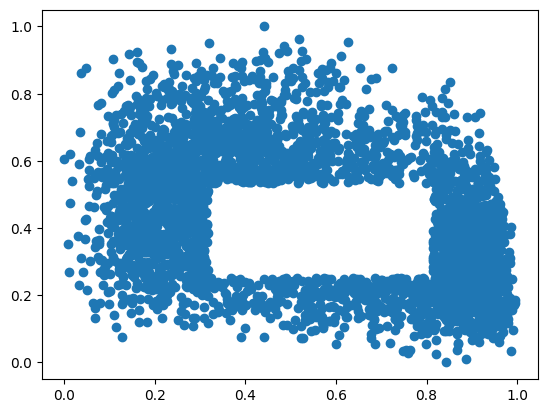

In [66]:
plt.scatter(df_MAD['F_Objectivity'], df_MAD['F_Subjectivity'])

In [67]:
## Repeating the splitting data in train (75%) and test (25%)
train_MAD, test_MAD = train_test_split(df_MAD, test_size=0.25, random_state=42)

## Generating data based on MAD selected points:
X_train_D, Y_train_D = generateData(train_MAD)
X_test_D, Y_test_D = generateData(test_MAD)

### E) MAD data for Multiclass
This data puts together the manipulation applied for (C) and (D) datasets.

In [68]:
## It makes use of Y_train_D and Y_test_D data.
Y_train_E = Y_train_D.copy()
Y_test_E = Y_test_D.copy()

## It also makes a copy of X datasets:
X_train_E = X_train_D.copy()
X_test_E = X_test_D.copy()

In [69]:
# Categorical binary labeling through list comprehension accordingly to SCA median criteria:
Y_train_E['F_Objectivity'] = [1 if f_objectivity >= 0.565 else 0 for f_objectivity in Y_train_E['F_Objectivity']]
Y_train_E['F_Subjectivity'] = [1 if f_subjectivity >= 0.392 else 0 for f_subjectivity in Y_train_E['F_Subjectivity']]

Y_test_E['F_Objectivity'] = [1 if f_objectivity >= 0.565 else 0 for f_objectivity in Y_test_E['F_Objectivity']]
Y_test_E['F_Subjectivity'] = [1 if f_subjectivity >= 0.392 else 0 for f_subjectivity in Y_test_E['F_Subjectivity']]

In [70]:
# Maps Y_train_C, Y_test_C values into a target column:
Y_train_E['target'] = Y_train_E.apply(map_labels, axis=1)
Y_test_E['target'] = Y_test_E.apply(map_labels, axis=1)

In [71]:
## Dropping unnecessariy columns:
Y_train_E.drop(['F_Objectivity','F_Subjectivity'], axis=1, inplace=True)
Y_test_E.drop(['F_Objectivity','F_Subjectivity'], axis=1, inplace=True)

In [72]:
Y_train_E.sample(5)

,target
context,Contextual
fabric,Manifest
claws,Perceptual
path,Manifest
fortune,Latent


---
## Model 01: MLP Classifier for word semantic content
- Multilayer perceptron with two continuous outputs between 0 and 1 (sigmoid)

In [73]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Training with data (A)

In [74]:
### Model 01: MLP architecture for continuous output:
model_01_A = Sequential([
    Dense(256, activation='relu', input_shape=(512,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Dense(2, activation='linear')  # 2 neurons for continuous output between 0 and 1
    Dense(2, activation='sigmoid')  # 2 neurons for continuous output between 0 and 1
], name='Model_01_A')

# Compile the model
model_01_A.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [75]:
# Print model summary
model_01_A.summary()

Model: "Model_01_A"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 174626 (682.13 KB)
Trainable params: 174626 (682.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
## Transforming data into numpy array:
Y_train_A_array = Y_train_A.to_numpy()
Y_test_A_array = Y_test_A.to_numpy()

X_train_A_array = X_train_A.to_numpy()
X_test_A_array = X_test_A.to_numpy()

# Print the first few elements to verify
print(Y_train_A_array[:5])  # Print the first 5 elements


[[0.36572243 0.64719766]
 [0.20112169 0.50717064]
 [0.77447234 0.29110657]
 [0.01346386 0.47490132]
 [0.81643835 0.2276313 ]]


In [77]:
# Train the model
history_01_A = model_01_A.fit(X_train_A_array, Y_train_A_array, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50



176/176 [==============================] - 2s 4ms/step - loss: 0.0239 - accuracy: 0.8131 - val_loss: 0.0160 - val_accuracy: 0.8663
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.8669 - val_loss: 0.0149 - val_accuracy: 0.8734
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.8914 - val_loss: 0.0149 - val_accuracy: 0.8848
Epoch 4/50
176/176 [==============================] - 0s 3ms/step - loss: 0.0089 - accuracy: 0.9096 - val_loss: 0.0157 - val_accuracy: 0.8691
Epoch 5/50
176/176 [==============================] - 0s 3ms/step - loss: 0.0063 - accuracy: 0.9238 - val_loss: 0.0151 - val_accuracy: 0.8905
Epoch 6/50
176/176 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 0.9373 - val_loss: 0.0153 - val_accuracy: 0.8919
Epoch 7/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9434 - val_loss: 0.0151 - val_accuracy: 0.8748
Epoch 8/50
176/17

In [78]:
# Evaluate the model
loss_01_A, accuracy_01_A = model_01_A.evaluate(X_test_A_array, Y_test_A_array)
print(f"{model_01_A.name}: Test Accuracy: {accuracy_01_A * 100:.2f}%")

37/37 [==============================] - 0s 2ms/step - loss: 0.0150 - accuracy: 0.8736
Model_01_A: Test Accuracy: 87.36%


#### Applying the trained model to predict SCA for a distinct word:

In [79]:
## Choosing an arbitrary word:
entry = 'monster'

In [80]:
## Getting its vector representation (from word embedding) and preparing it to the model input format:
new_entry = nlp_getVector(entry)[1]
new_entry = np.expand_dims(new_entry, axis=0)

In [81]:
## Showing how this entry is laid out:
new_entry

array([[-0.06711828, -0.02067498, -0.04206308, -0.01115861, -0.01383582,
         0.04510906,  0.0125503 ,  0.04529705, -0.01273363,  0.02883258,
         0.07125575,  0.02193494,  0.03173211, -0.02368355, -0.0614245 ,
        -0.00586793, -0.03555945, -0.04534414, -0.0763303 , -0.03360101,
        -0.00844153, -0.00830069, -0.03626368,  0.0785375 , -0.03493651,
        -0.01950266, -0.01525783, -0.04266157,  0.03850418,  0.02419825,
        -0.02083688, -0.01407638,  0.02044228,  0.07852259,  0.04340887,
         0.07285666, -0.00532492,  0.04861598,  0.03937482, -0.01199506,
         0.04909835,  0.04842913, -0.06813003, -0.08277766, -0.03305084,
         0.02141174, -0.05145124, -0.03189183, -0.0289927 , -0.01934705,
         0.08942617, -0.05437987,  0.07336873,  0.07985371,  0.02580532,
        -0.0114742 ,  0.02669582,  0.01450784,  0.0157063 ,  0.00816931,
        -0.00712485, -0.05875389, -0.01702816,  0.0709166 , -0.02216902,
         0.05185924, -0.0440516 ,  0.01301391,  0.0

In [82]:
## Predicting the objective and subjective loads for the 'entry' word:
result = model_01_A.predict(new_entry)
result

1/1 [==============================] - 0s 100ms/step


array([[0.77475625, 0.7370473 ]], dtype=float32)

In [83]:
## Generalizing the process above for any word through a python method:
def wordClassifier_regression(word, model=model_01_A):
    '''Given a word vector, shows the probability for objective and subjective semantic content, respectively.'''
    new_entry = nlp_getVector(word)
    if new_entry:
        vector = nlp_getVector(word)[1]
        vector = np.expand_dims(vector, axis=0)
        result = model.predict(vector)
    else:
        print('Word not existent in database.')
        return
    print(f'--- {word}:\n{result[0][0]*100:.2f} of objectivity\n{result[0][1]*100:.2f} of subjectivity')
    print(f'Model used: {model.name}')  # Print the name of the model
    return


In [85]:
## Experimenting with a trial word:
trial_word = 'hippopotamus'
wordClassifier_regression(trial_word)

1/1 [==============================] - 0s 25ms/step


--- hippopotamus:
95.59 of objectivity
36.98 of subjectivity
Model used: Model_01_A


In [90]:
## Experimenting with a trial word:
trial_phrase = 'I dreamed with a hippopotamus'
wordClassifier_regression(trial_phrase)

1/1 [==============================] - 0s 23ms/step
--- I dreamed with a hippopotamus:
76.03 of objectivity
63.14 of subjectivity
Model used: Model_01_A


In [91]:
## Checking the same trial word in the original SCA dataset (if available)
df_factors[df_factors['words']==trial_word]

,words,F_Objectivity,F_Subjectivity,F_Context
2387,hippopotamus,0.973593,0.377959,0.309328


### Training with data (D)

In [92]:
### Model 01: MLP architecture for continuous output:
model_01_D = Sequential([
    Dense(256, activation='relu', input_shape=(512,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Dense(2, activation='linear')  # 2 neurons for continuous output between 0 and 1
    Dense(2, activation='sigmoid')  # 2 neurons for continuous output between 0 and 1
], name='Model_01_D')

# Compile the model
model_01_D.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [93]:
# Print model summary
model_01_D.summary()

Model: "Model_01_D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
Total params: 174626 (682.13 KB)
Trainable params: 174626 (682.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
## Transforming data into numpy array:
Y_train_D_array = Y_train_D.to_numpy()
Y_test_D_array = Y_test_D.to_numpy()

X_train_D_array = X_train_D.to_numpy()
X_test_D_array = X_test_D.to_numpy()

# Print the first few elements to verify
print(Y_train_D_array[:5])  # Print the first 5 elements


[[0.15859087 0.58544867]
 [0.14240247 0.50945274]
 [0.95035619 0.17403995]
 [0.21539557 0.31870239]
 [0.25452163 0.66739412]]


In [95]:
# Train the model
history_01_D = model_01_D.fit(X_train_D_array, Y_train_D_array, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
131/131 [==============================] - 2s 4ms/step - loss: 0.0305 - accuracy: 0.8129 - val_loss: 0.0191 - val_accuracy: 0.8776
Epoch 2/50
131/131 [==============================] - 0s 3ms/step - loss: 0.0156 - accuracy: 0.9014 - val_loss: 0.0172 - val_accuracy: 0.8948
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9134 - val_loss: 0.0160 - val_accuracy: 0.9025
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 0.9220 - val_loss: 0.0167 - val_accuracy: 0.8910
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9388 - val_loss: 0.0155 - val_accuracy: 0.8948
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 0.9474 - val_loss: 0.0161 - val_accuracy: 0.8815
Epoch 7/50
131/131 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 0.9617 - val_loss: 0.0160 - val_accuracy: 0.8967
Epoch 

In [96]:
# Evaluate the model
loss_01_D, accuracy_01_D = model_01_D.evaluate(X_test_D_array, Y_test_D_array)
print(f"{model_01_D.name}: Test Accuracy: {accuracy_01_D * 100:.2f}%")

28/28 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.8898
Model_01_D: Test Accuracy: 88.98%


#### Applying Model_01_D to predict SCA for a distinct word:

In [97]:
## Experimenting with a trial word:
trial_word = 'child'
wordClassifier_regression(trial_word, model=model_01_A)
wordClassifier_regression(trial_word, model=model_01_D)

1/1 [==============================] - 0s 21ms/step
--- child:
86.78 of objectivity
37.10 of subjectivity
Model used: Model_01_A
1/1 [==============================] - 0s 74ms/step
--- child:
89.81 of objectivity
38.68 of subjectivity
Model used: Model_01_D


In [98]:
## Checking the same trial word in the original SCA dataset (if available)
df_factors[df_factors['words']==trial_word]

,words,F_Objectivity,F_Subjectivity,F_Context
859,child,0.90202,0.380464,0.233721


----
## Model 02: MLP for multilabel classification:
- Multilayer perceptron with a single multilabel output (softmax activation) based on SCA
- Output: Objective (0) or Subjective (1)

In [100]:
from sklearn.preprocessing import OneHotEncoder

### Training with data (C)

In [101]:
## Preparing data:
encoder_oneHot_C = OneHotEncoder()
Y_train_C_encoded = encoder_oneHot_C.fit_transform(Y_train_C[['target']]).toarray()
Y_test_C_encoded = encoder_oneHot_C.fit_transform(Y_test_C[['target']]).toarray()

In [102]:
## Transforming data into numpy array -- Y data was transformed above:
X_train_C_array = X_train_C.to_numpy()
X_test_C_array = X_test_C.to_numpy()

In [108]:
model_02_C = Sequential([
    Dense(480, activation='relu', input_shape=(X_train_C.shape[1],)), ## Equivalent to input_shape=(300,)
    Dense(300, activation='relu'),
    Dense(150, activation='relu'),
    Dense(100, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(Y_train_C_encoded.shape[1], activation='softmax')  # Output layer with softmax activation for multiclass classification
], name='Model_02_C')

# Compile the model
model_02_C.compile(optimizer='adam',
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [109]:
model_02_C.summary()

Model: "Model_02_C"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 480)               246240    
                                                                 
 dense_23 (Dense)            (None, 300)               144300    
                                                                 
 dense_24 (Dense)            (None, 150)               45150     
                                                                 
 dense_25 (Dense)            (None, 100)               15100     
                                                                 
 dense_26 (Dense)            (None, 64)                6464      
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 4)                 1

In [110]:
# Train the model
history_02_C = model_02_C.fit(X_train_C_array, Y_train_C_encoded, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
176/176 [==============================] - 2s 5ms/step - loss: 1.0135 - accuracy: 0.5803 - val_loss: 0.8517 - val_accuracy: 0.6373
Epoch 2/50
176/176 [==============================] - 1s 4ms/step - loss: 0.7378 - accuracy: 0.7077 - val_loss: 0.7803 - val_accuracy: 0.6686
Epoch 3/50
176/176 [==============================] - 1s 4ms/step - loss: 0.5924 - accuracy: 0.7558 - val_loss: 0.8785 - val_accuracy: 0.6486
Epoch 4/50
176/176 [==============================] - 1s 4ms/step - loss: 0.4456 - accuracy: 0.8270 - val_loss: 0.9264 - val_accuracy: 0.6401
Epoch 5/50
176/176 [==============================] - 1s 4ms/step - loss: 0.2833 - accuracy: 0.8936 - val_loss: 1.0602 - val_accuracy: 0.6486
Epoch 6/50
176/176 [==============================] - 1s 4ms/step - loss: 0.1973 - accuracy: 0.9313 - val_loss: 1.1969 - val_accuracy: 0.6273
Epoch 7/50
176/176 [==============================] - 1s 4ms/step - loss: 0.1220 - accuracy: 0.9598 - val_loss: 1.2918 - val_accuracy: 0.6358
Epoch 

In [111]:
# Evaluate the model
loss_02_C, accuracy_02_C = model_02_C.evaluate(X_test_C_array, Y_test_C_encoded)
print(f"{model_02_C.name}: Test Accuracy: {accuracy_02_C * 100:.2f}%")

 1/37 [..............................] - ETA: 0s - loss: 7.0732 - accuracy: 0.6250

37/37 [==============================] - 0s 2ms/step - loss: 4.7114 - accuracy: 0.6849
Model_02_C: Test Accuracy: 68.49%


### Training with data (E)

In [112]:
## Preparing data:
encoder_oneHot_E = OneHotEncoder()
Y_train_E_encoded = encoder_oneHot_E.fit_transform(Y_train_E[['target']]).toarray()
Y_test_E_encoded = encoder_oneHot_E.fit_transform(Y_test_E[['target']]).toarray()

In [113]:
## Transforming data into numpy array -- Y data was transformed above:
X_train_E_array = X_train_E.to_numpy()
X_test_E_array = X_test_E.to_numpy()

In [114]:
model_02_E = Sequential([
    Dense(300, activation='relu', input_shape=(X_train_E.shape[1],)), ## Equivalent to input_shape=(300,)
    Dense(150, activation='relu'),
    Dense(100, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(Y_train_E_encoded.shape[1], activation='softmax')  # Output layer with softmax activation for multiclass classification
], name='Model_02_E')

# Compile the model
model_02_E.compile(optimizer='adam',
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

model_02_E.summary()

Model: "Model_02_E"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 300)               153900    
                                                                 
 dense_30 (Dense)            (None, 150)               45150     
                                                                 
 dense_31 (Dense)            (None, 100)               15100     
                                                                 
 dense_32 (Dense)            (None, 64)                6464      
                                                                 
 dense_33 (Dense)            (None, 32)                2080      
                                                                 
 dense_34 (Dense)            (None, 4)                 132       
                                                                 
Total params: 222826 (870.41 KB)
Trainable params: 22282

In [115]:
# Train the model
history_02_E = model_02_E.fit(X_train_E_array, Y_train_E_encoded, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
131/131 [==============================] - 2s 5ms/step - loss: 0.9530 - accuracy: 0.6081 - val_loss: 0.7054 - val_accuracy: 0.7017
Epoch 2/50
131/131 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.7541 - val_loss: 0.6711 - val_accuracy: 0.7151
Epoch 3/50
131/131 [==============================] - 0s 3ms/step - loss: 0.4921 - accuracy: 0.7990 - val_loss: 0.7038 - val_accuracy: 0.7170
Epoch 4/50
131/131 [==============================] - 0s 3ms/step - loss: 0.3680 - accuracy: 0.8531 - val_loss: 0.7801 - val_accuracy: 0.7132
Epoch 5/50
131/131 [==============================] - 0s 3ms/step - loss: 0.2657 - accuracy: 0.9000 - val_loss: 0.9339 - val_accuracy: 0.7228
Epoch 6/50
131/131 [==============================] - 0s 3ms/step - loss: 0.1817 - accuracy: 0.9297 - val_loss: 0.9450 - val_accuracy: 0.7151
Epoch 7/50
131/131 [==============================] - 0s 3ms/step - loss: 0.1189 - accuracy: 0.9579 - val_loss: 1.0937 - val_accuracy: 0.7247
Epoch 

In [116]:
# Evaluate the model
loss_02_E, accuracy_02_E = model_02_E.evaluate(X_test_E_array, Y_test_E_encoded)
print(f"{model_02_E.name}: Test Accuracy: {accuracy_02_E * 100:.2f}%")

28/28 [==============================] - 0s 2ms/step - loss: 2.5722 - accuracy: 0.7394
Model_02_E: Test Accuracy: 73.94%


### Exploring Model 02 results

In [117]:
## Generalizing the process above for any word through a python method:
def wordClassifier_multiclass(word, model, encoder):
    '''Given a word vector, classifies its content as perceptual, manifest, contextual, or latent, according to SCA.
    Usage example: wordClassifier_multiclass(word='trial', model=model_02_C, encoder=encoder_oneHot_C).
    '''
    new_entry = nlp_getVector(word)
    if new_entry:
        vector = nlp_getVector(word)[1]
        vector = np.expand_dims(vector, axis=0)
        result = model.predict(vector)
        decoded_result = encoder.inverse_transform(result)
    else:
        print('Word not existent in database.')
        return
    print(f'--- SCA: "{word}" has {decoded_result[0][0]} content.')
    print(f'Model used: {model.name}')  # Print the name of the model
    return


In [118]:
## Experiment with a given word:
wordClassifier_multiclass('happyness',model=model_02_E, encoder=encoder_oneHot_E)
wordClassifier_multiclass('happyness',model=model_02_C, encoder=encoder_oneHot_C)

1/1 [==============================] - 0s 97ms/step
--- SCA: "happyness" has Latent content.
Model used: Model_02_E
1/1 [==============================] - 0s 82ms/step
--- SCA: "happyness" has Perceptual content.
Model used: Model_02_C


In [446]:
## Checking words classification based on the sequence explored in the PhD Thesis.
seq_words_A = ['imagination','care','fear','play','protection','monster','Mom','Dad','toy','child','doll']

for word in seq_words_A:
    wordClassifier_multiclass(word,model=model_02_E, encoder=encoder_oneHot_E)
    # print('\n')
    wordClassifier_multiclass(word,model=model_02_C, encoder=encoder_oneHot_C)
    print(f'\n{25*"-"}')

1/1 [==============================] - 0s 31ms/step
--- SCA: "imagination" has Latent content.
Model used: Model_02_E
1/1 [==============================] - 0s 20ms/step
--- SCA: "imagination" has Latent content.
Model used: Model_02_C

-------------------------
1/1 [==============================] - 0s 90ms/step
--- SCA: "care" has Latent content.
Model used: Model_02_E
1/1 [==============================] - 0s 22ms/step
--- SCA: "care" has Latent content.
Model used: Model_02_C

-------------------------
1/1 [==============================] - 0s 21ms/step
--- SCA: "fear" has Latent content.
Model used: Model_02_E
1/1 [==============================] - 0s 22ms/step
--- SCA: "fear" has Latent content.
Model used: Model_02_C

-------------------------
1/1 [==============================] - 0s 23ms/step
--- SCA: "play" has Perceptual content.
Model used: Model_02_E
1/1 [==============================] - 0s 25ms/step
--- SCA: "play" has Perceptual content.
Model used: Model_02_C

--------

In [449]:
## Checking words classification based on the sequence explored in the PhD Thesis.
seq_words_B = ['pleasure','love','anxiety','suffering','touch','hug','cuddle','wound','arms','hand']

for word in seq_words_B:
    wordClassifier_multiclass(word,model=model_02_E, encoder=encoder_oneHot_E)
    # print('\n')
    wordClassifier_multiclass(word,model=model_02_C, encoder=encoder_oneHot_C)
    print(f'\n{25*"-"}')

1/1 [==============================] - 0s 28ms/step
--- SCA: "pleasure" has Latent content.
Model used: Model_02_E
1/1 [==============================] - 0s 20ms/step
--- SCA: "pleasure" has Latent content.
Model used: Model_02_C

-------------------------
1/1 [==============================] - 0s 39ms/step
--- SCA: "love" has Latent content.
Model used: Model_02_E
1/1 [==============================] - 0s 23ms/step
--- SCA: "love" has Latent content.
Model used: Model_02_C

-------------------------
1/1 [==============================] - 0s 28ms/step
--- SCA: "anxiety" has Latent content.
Model used: Model_02_E
1/1 [==============================] - 0s 22ms/step
--- SCA: "anxiety" has Latent content.
Model used: Model_02_C

-------------------------
1/1 [==============================] - 0s 27ms/step
--- SCA: "suffering" has Latent content.
Model used: Model_02_E
1/1 [==============================] - 0s 24ms/step
--- SCA: "suffering" has Latent content.
Model used: Model_02_C

------

In [125]:
phrase = 'A cigar is just a cigar'
wordClassifier_multiclass(phrase,model=model_02_E, encoder=encoder_oneHot_E)

1/1 [==============================] - 0s 22ms/step
--- SCA: "A cigar is just a cigar" has Manifest content.
Model used: Model_02_E


In [131]:
phrase = 'Did you dream again?'
wordClassifier_multiclass(phrase,model=model_02_E, encoder=encoder_oneHot_E)

1/1 [==============================] - 0s 24ms/step
--- SCA: "Did you dream again?" has Latent content.
Model used: Model_02_E


### NEXT STEPS:  
Calcular a objetividade/subjetividade para cada frase da SICK database. 

----
## Saving and loading Keras trained models

In [119]:
# ## Saving Keras models for posterior use:
# model_01_A.save('../models/model_01_A.h5')
# model_01_D.save('../models/model_01_D.h5')
# model_02_C.save('../models/model_02_C.h5')
# model_02_E.save('../models/model_02_E.h5')

In [458]:
## Loading saved models:
from keras.models import load_model

In [462]:
model = load_model('../models/model_02_C.h5')

In [467]:
## Saving and loading Scklearn models (e.g., OneHot Encoders)
with open('../models/encoder_oneHot_C.pickle', 'wb') as f:
    pickle.dump(encoder_oneHot_C, f)

with open('../models/encoder_oneHot_E.pickle', 'wb') as f:
    pickle.dump(encoder_oneHot_E, f)

In [469]:
## Loading saved encoder:
with open('../models/encoder_oneHot_C.pickle', 'rb') as f:
    encoder = pickle.load(f)

### Trying loaded model and encoder:

In [470]:
wordClassifier_multiclass('debug',model=model, encoder=encoder)

1/1 [==============================] - 0s 75ms/step
--- SCA: "debug" has Latent content.
Model used: Model_02_C


---
## Pycaret: exploring outperforming models

In [302]:
import pycaret.classification

In [303]:
df_pycaret = pd.concat([X_train_C, Y_train_C], axis=1)
df_pycaret.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,target
garment,-2.44960,-0.709460,-1.4459,2.7438,2.19640,0.62562,1.3016,2.0838,-2.2201,-2.2038,...,3.413000,0.53852,-0.15337,-4.65310,0.54157,1.41030,-4.592600,0.43055,0.35458,Manifest
oven,-2.32870,1.487700,-1.1173,4.4829,1.85580,1.05840,1.8389,-2.3667,-6.2502,3.5786,...,0.578500,-2.85220,-4.87860,-0.81042,-1.06000,1.10440,0.489910,2.73810,3.74540,Manifest
landscape,-0.63003,0.041465,-2.3347,-4.7172,0.10905,-1.18150,3.3926,3.1072,-2.1309,1.3538,...,-0.072589,1.17210,0.39403,0.82975,-0.17167,-0.54614,0.039231,-4.14750,0.87988,Perceptual


In [304]:
## Fazendo um experimento:
exp_class = pycaret.classification.setup(df_pycaret, target='target', session_id=9088)

,Description,Value
0,Session id,9088
1,Target,target
2,Target type,Multiclass
3,Target mapping,"Contextual: 0, Latent: 1, Manifest: 2, Perceptual: 3"
4,Original data shape,"(3511, 301)"
5,Transformed data shape,"(3511, 301)"
6,Transformed train set shape,"(2457, 301)"
7,Transformed test set shape,"(1054, 301)"
8,Numeric features,300
9,Preprocess,True


In [305]:
exp_class.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:55:05
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6789,0.0000,0.6789,0.6689,0.6675,0.5516,0.5552,0.0220
lda,Linear Discriminant Analysis,0.6777,0.8846,0.6777,0.6770,0.6758,0.5564,0.5573,0.0560
lightgbm,Light Gradient Boosting Machine,0.6712,0.8857,0.6712,0.6594,0.6541,0.5381,0.5441,2.0130
gbc,Gradient Boosting Classifier,0.6590,0.8830,0.6590,0.6475,0.6451,0.5227,0.5270,13.9600
lr,Logistic Regression,0.6443,0.8568,0.6443,0.6458,0.6440,0.5121,0.5128,0.6520
svm,SVM - Linear Kernel,0.6325,0.0000,0.6325,0.6294,0.6254,0.4924,0.4956,0.0560
rf,Random Forest Classifier,0.6305,0.8571,0.6305,0.6097,0.5810,0.4691,0.4888,0.3810
et,Extra Trees Classifier,0.6260,0.8647,0.6260,0.6127,0.5636,0.4588,0.4857,0.1060
knn,K Neighbors Classifier,0.6215,0.8314,0.6215,0.6134,0.6043,0.4684,0.4747,0.2140
qda,Quadratic Discriminant Analysis,0.6125,0.7806,0.6125,0.5969,0.4932,0.4298,0.4790,0.0360


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=9088, solver='auto',
                tol=0.0001)